In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

from src.V1_Compress import generate_Y, compress
import pandas as pd
import itertools
import dask
from dask.distributed import Client, progress
import seaborn as sns
import time
import os.path

In [2]:
def opt_hyperparams(data): 
    # Try to use pd group_by to group repetition and get avg
    
    # Among those average, get the lowest error hyperparam
    ordered_data = pd.DataFrame(data).sort_values(by = 'error', ascending = True)
    print(ordered_data.head(5))
    
    return ordered_data.head(1)

In [3]:
def run_sim(rep, alp, num, sz, freq, img_arr):
    num = int(num)
    img_arr = np.array([img_arr]).squeeze()
    dim = img_arr.shape
    n, m = dim

    # Generate V1 weight with y
    W = V1_weights(num, dim, sz, freq) 
    y = generate_Y(W, img_arr)
    W_model = W.reshape(num, n, m)
    
    # Call function and calculate error
    theta, reform, s = compress(W_model, y, alp)
    error = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
    
    return error, theta, reform, s

In [4]:
#DF version after looking at Desk method

# Set up hyperparameters that would affect results
param = []
params = []
# result = []
alpha = np.logspace(-3, 3, 7)
rep = np.arange(10)
num_cell = [100, 200, 500]
cell_sz = [2, 5, 7]
sparse_freq = [1, 2, 5]

# Load Image
image_nm = 'image/tree_part1.jpg'
img = Image.open(image_nm)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)



search_list = [rep, alpha, num_cell, cell_sz, sparse_freq]
search = list(itertools.product(*search_list))             
search_df = pd.DataFrame(search, columns= [ 'rep', 'alp', 'num_cell', 'cell_sz', 'sparse_freq'])
print(search_df.head())

# Call dask
client = Client()
client

# counter = 0; # Keep track of number of iteration. Debugging method
for p in search_df.values:
    param = dask.delayed(run_sim)(*p, img_arr)
    params.append(param)

futures = dask.persist(*params)
progress(futures)

# Compute the result
results = dask.compute(*futures)
pd.DataFrame(results)

   rep    alp  num_cell  cell_sz  sparse_freq
0    0  0.001       100        2            1
1    0  0.001       100        2            2
2    0  0.001       100        2            5
3    0  0.001       100        5            1
4    0  0.001       100        5            2


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(results)

In [ ]:
# This works but other ways does not work at all for no reason

params = []
reformed = []
alpha = np.logspace(-3, 3, 7)
rep = np.arange(10)
results = []

# Load Image
image_nm = 'image/tree_part1.jpg'
img = Image.open(image_nm)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)


# Load V1 weight
search_list = {'repetition': rep,
               'alpha': alpha,
               'num_cell': [100, 200, 500],
               'cell_sz': [2, 5, 7],
               'sparse_freq': [1, 2, 5]
              }

dim = img_arr.shape
n, m = dim

# use itertool to reduce amount of for loops
for row in itertools.product(*search_list.values()):
    product = dict(zip(search_list.keys(), row))
    rep, alp, num, sz, freq = product.values()
    W = V1_weights(num, dim, sz, freq) 
    y = generate_Y(W, img_arr)
    W_model = W.reshape(num, n, m)
    
    theta, reform, s = compress(W_model, y, alp)
    error = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
    
    
    
    params.append({'repetition' : rep,
                   'num_cell' : num,
                   'cell_size' : sz,
                   'sparse_freq' : freq,
                   'alpha': alp,
                   'error' : error
                  })
    
    
    results.append({'s' : s,
                    'theta' : theta,
                    'reform' : reform
                   })
# opt_param = opt_hyperparams(params)

In [ ]:
#Saving 
save_path = os.path.join('./result/')
params_df = pd.DataFrame(params)
results_df = pd.DataFrame(results)

total_df = params_df.join(results_df)

params_df.to_csv(os.path.join(save_path, "param_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))
results_df.to_csv(os.path.join(save_path, "results_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))
total_df.to_csv(os.path.join(save_path, "total_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))


In [ ]:
# Work on previously saved data
params_df = pd.read_csv('result//param_Mon_May_23_21_46_49_2022.csv')
results_df = pd.read_csv('result//results_Mon_May_23_21_46_49_2022.csv')
total_df = pd.read_csv('result//total_Mon_May_23_21_47_07_2022.csv')

In [ ]:
params_df

In [ ]:
W

In [ ]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', hue = 'cell_size')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each cell_size')

In [ ]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line', palette='Accent', hue = 'sparse_freq')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='error for each cell_size')

In [ ]:
fig = sns.relplot(data = params_df, x = 'alpha', y = 'error', kind='line')
fig.set(yscale='log')
fig.set(xscale='log')
fig.set(title='Error for each penalty')

distributed.worker - WARNING - Compute Failed
Function:  run_sim
args:      (7.0, 10.0, 200.0, 2.0, 5.0, array([[213, 210, 216, 216, 206, 208, 216, 214, 193, 216, 233, 178, 196,
        141, 117, 134, 176, 112, 167, 160, 186, 213, 190, 177, 203, 182,
        195, 202, 185, 180],
       [220, 206, 204, 208, 208, 214, 215, 204, 228, 227, 203, 159, 174,
        142,  93,  95, 115, 122, 144, 163, 181, 158, 205, 163, 165, 193,
        201, 190, 187, 179],
       [207, 195, 196, 203, 207, 214, 216, 204, 199, 184, 145, 131, 164,
        171, 115, 105,  70, 102, 101, 117, 125,  86, 147, 109, 143, 204,
        196, 176, 195, 194],
       [190, 187, 197, 202, 195, 195, 197, 189, 192, 160, 111,  75, 106,
        124, 100, 101, 108,  96,  96,  93,  93, 100,  99, 117, 146, 189,
        174, 170, 192, 203],
       [198, 194, 200, 202, 190, 180, 169, 152, 183, 172, 167, 112, 129,
        108,  94,  87, 131, 104,  95, 106, 100, 141, 101, 168, 148, 165,
        169, 191, 177, 191],
       [214, 202, 20

In [ ]:
# To show how consistent randomly generated V1 weight would be for each rep. it should be about same for each repetition


fig = sns.relplot(data = params_df, x = 'repetition', y = 'error', kind='line', palette='Accent', hue = 'alpha')
fig.set(title='error consistency')
fig.set(yscale='log')

In [ ]:
sns.relplot(data = params_df, x = 'repetition', y = 'error', kind='line', palette='Accent', hue = 'alpha')

In [ ]:
plt.figure(figsize=(3, 3))
fig = sns.relplot()

In [ ]:

alpha = np.logspace(-3, 3, 7)
rep = np.arange(10)
num_cell = [100, 200, 500]
cell_sz = [2, 5, 7]
sparse_freq = [1, 2, 5]

# Load Image
image_nm = 'city_part3.png'
img = Image.open('image/' + image_nm)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)

dim = img_arr.shape
n, m = dim

# Load V1 weight
# search_list = {'repetition': rep,
#                'alpha': alpha,
#                'num_cell': ,
#                'cell_sz': [2, 5, 7],
#                'sparse_freq': [1, 2, 5]
#               }

temp_alp = 3
temp_num = 200
temp_sz = 5
temp_freq = 5

temp_dim = img_arr.shape

temp_W = V1_weights(temp_num, dim, temp_sz, temp_freq)


search_list = [rep, alpha, num_cell, cell_sz, sparse_freq]
search = list(itertools.product(*search_list))             
search_df = pd.DataFrame(search, columns= [ 'rep', 'alp', 'num_cell', 'cell_sz', 'sparse_freq'])


result = pd.DataFrame(columns=['s', 'theta', 'reform', 'error'])
# use itertool to reduce amount of for loops
# for row in itertools.product(*search_list.values()):

search_result = []
print("start for loop")
for rep, alp, num, sz, freq in list(search_df.values):
    print("repetition:", rep, "alpha:", alp, "num_Cell:", num, "Cell Size:", sz, 
          "Cell_Freq:", freq, "Dim", dim[0], dim[1])
    
    # fix the classes of hyperparameter from float to int if needed
    rep = int(rep)
    num = int(num)
    sz = int(sz)
    freq = int(freq)

    # Generate V1 weight with Y values
    W = V1_weights(num, dim, sz, freq) 
    y = generate_Y(W, img_arr)
    W_model = W.reshape(num, n, m)

    # Compute bio-reconstruction of image with error
    theta, reform, s = compress(W_model, y, alp)
    error = np.linalg.norm(img - reform, 'fro') / np.sqrt(m*n)
    print("Error:", error)
    
    # Save result 
    search_result.append({'repetition' : rep,
                          'num_cell' : num,
                          'cell_size' : sz,
                          'sparse_freq' : freq,
                          'alpha': alp,
                          'error' : error
                         })
opt_param = opt_hyperparams(search_result)

## Optimal hyperparam
### tree_part1.jpg
####  num_cell: 500,  cell_size: 5,   sparse_freq: 2,   alpha: 0.01,      error: 12.434444

### city_part2.png
#### num_cell: 500,  cell_size: 7,  sparse_freq: 2,  alpha: 0.01     error: 8.087927

### city_part3.png
#### num_cell: 500,  cell_size: 2,  sparse_freq: 1,  alpha: 0.10     error: 14.200209

In [ ]:
#Saving 
save_path = os.path.join('./result/')

results_df = pd.DataFrame(search_result)

results_df.to_csv(os.path.join(save_path, "city_part3_results_" + "_".join(str.split(time.ctime().replace(":", "_"))) + ".csv"))


In [ ]:
repetition, num_cell_h, cell_size_h, sparse_freq_h, alpha_h, error = opt_param.values.ravel()

In [ ]:
#Compress Sensing on function

In [6]:
## Check if this function is applicable to regular compress sensing
classical_img = Image.open("image/tree_part1.jpg")
classical_img = ImageOps.grayscale(classical_img)
classical_arr = np.asarray(classical_img)
cn, cm = classical_arr.shape
print(cn, cm)
classical_samp_list = [100, 200, 500] #np.floor (cn * cm * 0.20).astype(int)
classical_samp = 500

30 30


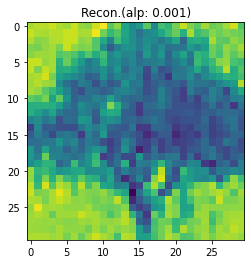

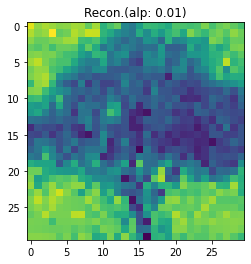

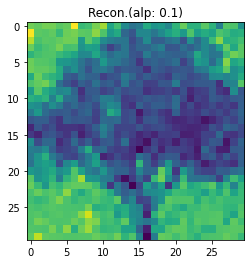

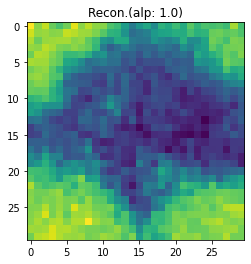

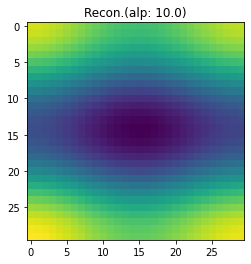

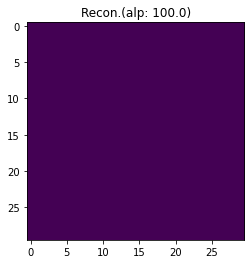

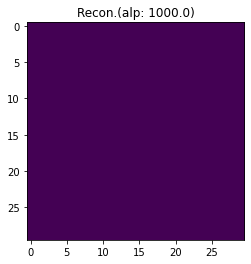

In [11]:
alpha_list = np.logspace(-3, 3, 7)


for alp in alpha_list:
    # Generate random indexes and find corresponding y value for each index
    rand_index = np.random.permutation(cn * cm)[:classical_samp]
    classical_Y = classical_arr.flatten()[rand_index]
    classical_Y = classical_Y.reshape(classical_samp, 1)

    # Generate C matrix
    C = np.eye(cn * cm)[rand_index, :] * np.sqrt(cn * cm)
    C3D = C.reshape(classical_samp, cn, cm)
    theta, classical_reform, s = compress(C3D, classical_Y, alp)

    plt.imshow(classical_reform)
    plt.title("Recon.(alp: " + str(alp) + ")")
    plt.show()
    if (alp == 0.001):
        save = classical_reform

In [12]:
error = np.

array([[ 2.25733880e+00,  2.51080268e+00,  2.47885384e+00,
         2.71114371e+00,  2.37765419e+00,  2.21084867e+00,
         2.71190437e+00,  2.11529331e+00,  1.94404654e+00,
         2.71141663e+00,  3.27664686e+00,  1.39746804e+00,
         2.04369276e+00,  1.70004126e-01, -5.89049946e-01,
        -2.19206950e-02,  1.37707332e+00, -7.54751625e-01,
         1.07785599e+00,  7.13000229e-01,  1.72922980e+00,
         2.61047156e+00,  1.84352403e+00,  1.41052869e+00,
         2.27703776e+00,  1.57768825e+00,  1.76494374e+00,
         2.24339455e+00,  2.74972884e+00,  1.23756642e+00],
       [ 2.66528557e+00,  2.37760708e+00,  2.31133992e+00,
         2.44416158e+00,  2.44333028e+00,  2.64406816e+00,
         2.67735221e+00,  2.31148604e+00,  2.33754313e+00,
         3.07690228e+00,  1.69560238e+00,  8.11223745e-01,
         1.31110205e+00,  2.44178449e-01, -4.41219415e-01,
        -1.32153273e+00, -6.54972384e-01, -4.22258429e-01,
         3.11881572e-01,  9.43654857e-01,  1.54399764e+

In [ ]:
opt_hyperparams(params_df)

In [ ]:
img_list1 = ["image/tree_part1.jpg", "image/city_part2.png"]


for im in img_list1:
    img = Image.open(im)
    img = ImageOps.grayscale(img)
    img_arr = np.asarray(img)

    # V1 Variables
    num_cell = 500
    cell_size = 7
    sparse_freq = 2
    dim = img_arr.shape
    n,m = dim

    W = V1_weights(num_cell, dim, cell_size, sparse_freq) 
    y = generate_Y(W, img_arr)
    W_rev = W.reshape(num_cell, n, m)
    theta, reform, s = compress(W_rev, y, 0.01)
    plt.imshow(reform)
    plt.show()

In [ ]:
# Classical Method
tree_img = Image.open("image/tree_part1.jpg")
tree_img = ImageOps.grayscale(tree_img)
tree_img_arr = np.asarray(tree_img)

city_img = Image.open("image/city_part2.png")
city_img = ImageOps.grayscale(city_img)
city_img_arr = np.asarray(city_img)

# V1 Optimized Variables
classical_samp = 100
dim = tree_img_arr.shape
n, m = dim
alp = 0.003

rand_index_tree = np.random.permutation(n * m)[:classical_samp]
classical_Y_tree = tree_img_arr.flatten()[rand_index_tree]
classical_Y_tree = classical_Y_tree.reshape(classical_samp, 1)

rand_index_city = np.random.permutation(n * m)[:classical_samp]
classical_Y_city = city_img_arr.flatten()[rand_index_city]
classical_Y_city = classical_Y_city.reshape(classical_samp, 1)

# Generate C matrix for tree
C_tree = np.eye(n * m)[rand_index_tree, :] #* np.sqrt(n * m)
C3D_tree = C_tree.reshape(classical_samp, n, m)

# Generate C matrix for city
C_city = np.eye(n * m)[rand_index_city, :] #* np.sqrt(n * m)
C3D_city = C_city.reshape(classical_samp, n, m)



# Fetch into function
theta_tree, classical_recons_tree, s_tree = compress(C3D_tree, classical_Y_tree, alp)
theta_city, classical_recons_city, s_city = compress(C3D_city, classical_Y_city, alp)

In [ ]:
# Show Original/Reconstructed image
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(3, 2, 1)
plt.imshow(tree_img)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 2)
plt.imshow(city_img)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 3)
plt.imshow(classical_recons_tree)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 4)
plt.imshow(classical_recons_city)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 5)
plt.imshow(tree_img_arr - classical_recons_tree)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 6)
plt.imshow(city_img_arr - classical_recons_city)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)



In [ ]:
# V1 Methods
tree_img = Image.open("image/tree_part1.jpg")
tree_img = ImageOps.grayscale(tree_img)
tree_img_arr = np.asarray(tree_img)

city_img = Image.open("image/city_part2.png")
city_img = ImageOps.grayscale(city_img)
city_img_arr = np.asarray(city_img)

# V1 Optimized Variables
num_cell = 100
cell_size = 7
sparse_freq = 2
dim = img_arr.shape
n,m = dim
alp = 1

W = V1_weights(num_cell, dim, cell_size, sparse_freq) 
y_tree = generate_Y(W, tree_img_arr)
y_city = generate_Y(W, city_img_arr)
W_rev = W.reshape(num_cell, n, m)
theta_tree, recons_tree, s_tree = compress(W_rev, y_tree, alp)
theta_city, recons_city, s_city = compress(W_rev, y_city, alp)

plt.imshow(recons_tree)

In [ ]:
# Show Original/Reconstructed image
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(3, 2, 1)
plt.imshow(tree_img)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 2)
plt.imshow(city_img)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 3)
plt.imshow(recons_tree)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 4)
plt.imshow(recons_city)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 5)
plt.imshow(tree_img_arr - recons_tree)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(3, 2, 6)
plt.imshow(city_img_arr - recons_city)
axes = plt.gca()
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)



In [ ]:
tree_img_arr

In [15]:
classical_recons_tree

NameError: name 'classical_recons_tree' is not defined

0.5555555555555556

1. Save all the images for hyperparams, and hyperparams as well, save original image along with it
2. Try same with compress sensing
